In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((515, 12, 1), (515,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 27s 352ms/step - loss: 0.2254 - root_mean_squared_error: 0.4748 - val_loss: 0.1172 - val_root_mean_squared_error: 0.3424
Epoch 2/50
53/53 [==============================] - 17s 329ms/step - loss: 0.1133 - root_mean_squared_error: 0.3367 - val_loss: 0.0873 - val_root_mean_squared_error: 0.2954
Epoch 3/50
53/53 [==============================] - 17s 332ms/step - loss: 0.0922 - root_mean_squared_error: 0.3037 - val_loss: 0.0793 - val_root_mean_squared_error: 0.2816
Epoch 4/50
53/53 [==============================] - 20s 385ms/step - loss: 0.0777 - root_mean_squared_error: 0.2788 - val_loss: 0.0752 - val_root_mean_squared_error: 0.2742
Epoch 5/50
53/53 [==============================] - 20s 374ms/step - loss: 0.0580 - root_mean_squared_error: 0.2408 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 6/50
53/53 [==============================] - 20s 377ms/step - loss: 0.0255 - root_mean_squared_error: 0.1597 - val_loss: 0.0075 

53/53 [==============================] - 3s 57ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 38/50
53/53 [==============================] - 3s 63ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 39/50
53/53 [==============================] - 3s 49ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 40/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 41/50
53/53 [==============================] - 3s 53ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 42/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0034 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.174677395820618 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

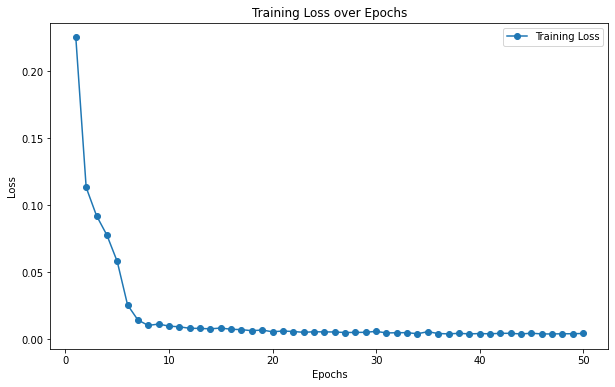

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

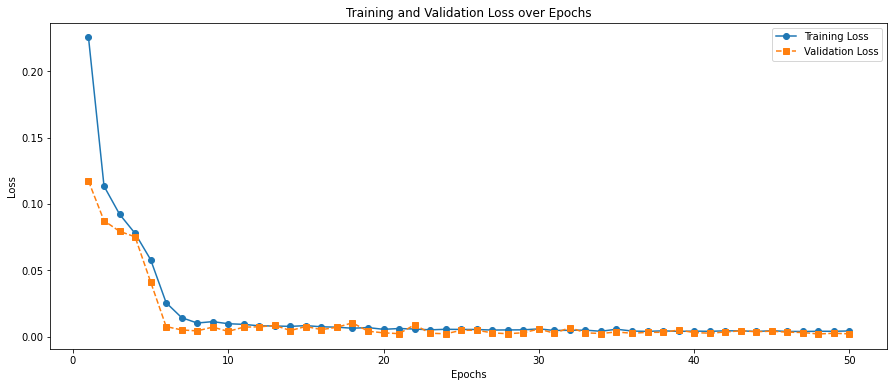

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 18ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.04733210014617738
MAE : 0.037921528305089505


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5.106559e+05,827036.916
1,1.116633e+06,1142021.216
2,1.780064e+06,1885693.654
3,2.403676e+06,2542569.663
4,2.996460e+06,3107373.845
5,3.460426e+06,3488175.444
6,3.532638e+06,3746306.528
7,3.069508e+06,2942322.822
8,1.432664e+06,1507212.955
9,4.499154e+05,648507.437


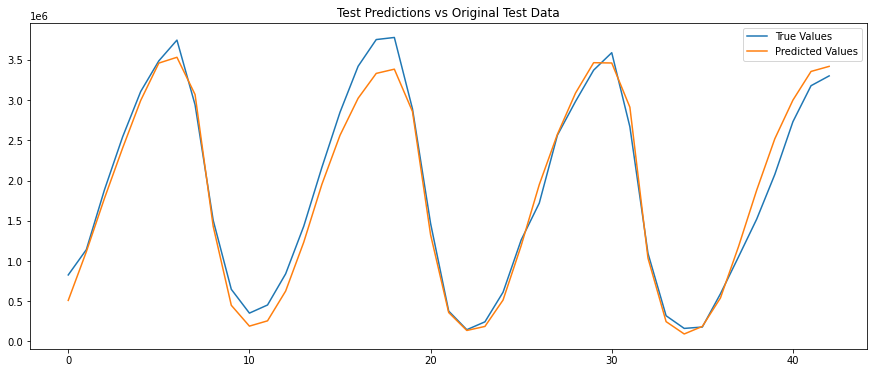

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 19ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

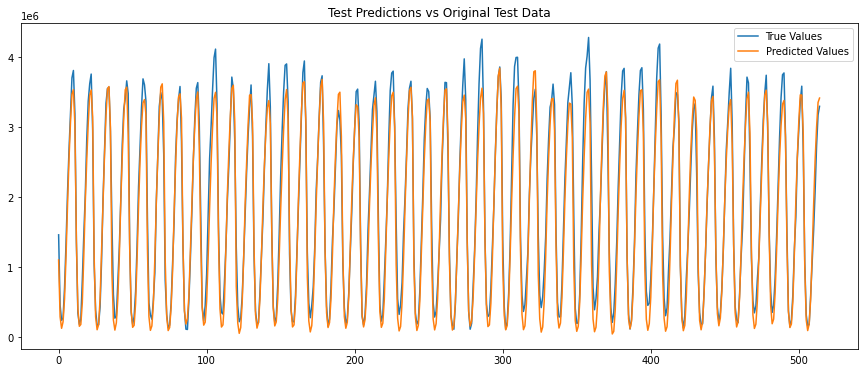

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()